# **2D Super-resolution pipeline**
___  
  
In this notebook, we demonstrate the use of the [BiaPy](https://biapyx.github.io/) pipeline for **2D super-resolution**, for reconstructing high-resolution (HR) images from low-resolution (LR).

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/LR_sr.png' width='250px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/HR_sr.png' width='250px'/>
<figcaption><b>Figure 1</b>: Example of a 2D super-resolution problem. Images obtained from <a href="https://www.dropbox.com/s/9f9xat4jbgkdchh/F-actin-small.zip?dl=0">F-actin dataset</a> provided in <a href="https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki">ZeroCostDL4Mic</a> notebooks for super-resolution.</figcaption></center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus), [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org) and [Ane Paniagua](mailto:anepaniagua@gmail.com). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!


## **Expected inputs and outputs**
___
### **Inputs**

This notebook expects five folders as input:
* **Training LR images**: with the low resolution 2D images to train the model.
* **Training HR images**: with the high resolution 2D images to train the model. Their number and sizes must match those of the training raw images.
* **Test LR images**: with the raw 2D images to test the model.
* **Test HR images**: with the high resolution 2D images to test the model. Their number and sizes must match those of the validation raw images.
* **Output folder**: a path to store the super-resolution results.

**Outputs**

Upon successful execution, a new folder will be generated containing one result **TIFF image** for every test image. These result images will showcase the instances of the objects of interest as determined by our pipeline.

<font color='red'><b>Note:</b></font> For testing, this notebook can be executed using the **example datasets found under 'Manage file(s) source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
├── train
│   ├── LR
│   │   ├── training-0001.tif
│   │   ├── training-0002.tif
│   │   ├── . . .
│   │   ├── training-9999.tif
│   └── HR
│       ├── training_groundtruth-0001.tif
│       ├── training_groundtruth-0002.tif
│       ├── . . .
│       ├── training_groundtruth-9999.tif
└── test
    ├── LR
    │   ├── testing-0001.tif
    │   ├── testing-0002.tif
    │   ├── . . .
    │   ├── testing-9999.tif
    └── HR
        ├── testing_groundtruth-0001.tif
        ├── testing_groundtruth-0002.tif
        ├── . . .
        ├── testing_groundtruth-9999.tif
```

**⚠️ Warning:** Ensure that low-resolution images and their corresponding high-resolution images are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).


## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.

### **Option 1: Upload Files from Your Local Machine**
---

When you select this option, you'll be prompted to upload your files to Colab. Once uploaded, they will be stored in the `/content/input/` directory.


In [ ]:
#@markdown ##Play the cell to upload local files (train LR images)
from google.colab import files
!mkdir -p /content/input/train/LR
%cd /content/input/train/LR
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (train HR images)

from google.colab import files
!mkdir -p /content/input/train/HR
%cd /content/input/train/HR
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test LR images)

from google.colab import files
!mkdir -p /content/input/test/LR
%cd /content/input/test/LR
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test HR images)

from google.colab import files
!mkdir -p /content/input/test/HR
%cd /content/input/test/HR
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use the [F-actin dataset](https://www.dropbox.com/s/9f9xat4jbgkdchh/F-actin-small.zip?dl=0) shared in [ZeroCostDL4Mic](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for super-resolution notebooks.

In [ ]:
#@markdown ##Play to download an example dataset
!pip install gdown==5.1.0 --quiet
import gdown
import os

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=1rtrR_jt8hcBEqvwx_amFBNR7CMP5NXLo", "data_2d.zip", quiet=True)

!unzip -q data_2d.zip
!rm data_2d.zip

print('Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_lr_data_path` to `/content/input/train/LR`
  - Set `train_hr_data_path` to `/content/input/train/HR`
  - Set `test_lr_data_path` to `/content/input/test/LR`
  - Set `test_hr_data_path` to `/content/input/test/HR`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_lr_data_path` to `/content/data/train/LR`
  - Set `train_hr_data_path` to `/content/data/train/HR`
  - Set `test_lr_data_path` to `/content/data/test/LR`
  - Set `test_hr_data_path` to `/content/data/test/HR`
  - Set `output_path` to `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_lr_data_path = '/content/data/train/LR' #@param {type:"string"}
#@markdown #####Path to train images
train_hr_data_path = '/content/data/train/HR' #@param {type:"string"}
#@markdown #####Path to test images
test_lr_data_path = '/content/data/test/LR' #@param {type:"string"}
#@markdown #####Path to test images
test_hr_data_path = '/content/data/test/HR' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Dataset Visualization**
---

In [ ]:
# @markdown ## Play to visualize some data samples
%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import os
from ipywidgets import interact, IntSlider, Layout, Dropdown, HBox, Output

# Initialize paths and image IDs
input_path = train_lr_data_path
gt_path = train_hr_data_path

ids_input = sorted(next(os.walk(input_path))[2])
ids_gt = sorted(next(os.walk(gt_path))[2])

# Create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

# Dropdown widget to choose training or test set
dropdown = Dropdown(
    options=['training-set', 'test-set'],
    value='training-set',
    description='Set:',
    disabled=False,
)

# Slider widget to choose instance
slider= IntSlider(
    value=0,
    min=1,
    max=len(ids_input),
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

slider.style.description_width = 'initial'
slider.style.handle_color='blue'

# Initialize Output instance to handle code output cell
output = Output()

# Function to display images depending on slider value
def display_images(change):
    with output:
        output.clear_output(wait=True)
        index = change['new']

        global input_path, ids_input, gt_path, ids_gt
        input_img_path = os.path.join(input_path, ids_input[index-1])
        input_img = imread(input_img_path)

        # # Print sample path to ensure the image displayed is correct
        # print(f"Sample path: {input_img_path}")

        # Display images
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Input image: {index}")
        plt.imshow(input_img, cmap='magma')
        # plt.axis('off')

        if ids_gt != []: # If StopIteration exception was not thrown
            gt_img_path = os.path.join(gt_path, ids_gt[index-1])
            gt_img = imread(gt_img_path)

            # # Print gt path to ensure the image displayed is correct
            # print(f"GT path: {gt_img_path}")

            plt.subplot(1, 2, 2)
            plt.title("Label")
            plt.imshow(gt_img,  cmap='magma')
            # plt.axis('off')
        else:
            print("No labels for this set.")
        plt.show()

# Function to update paths and image IDs (input_path, ids_input, gt_path, ids_gt)
def update_paths(change):
    global input_path, gt_path
    if change.new == 'test-set':
        input_path = test_lr_data_path
        gt_path = test_hr_data_path
    else:
        input_path = train_lr_data_path
        gt_path = train_hr_data_path

    # Update image IDs based on the new paths
    global ids_input, ids_gt
    ids_input = sorted(next(os.walk(input_path))[2])
    try:
        ids_gt = sorted(next(os.walk(gt_path))[2])
    except StopIteration:
        ids_gt = []

    # Reset slider value to 1 when dropdown changes
    slider.value = 1
    slider.max = len(ids_input)
    display_images({'new': 1})

# Create an HBox to hold the dropdown and slider
controls = HBox([dropdown, slider])
display(controls, output)

# Link widgets to functions
slider.observe(display_images, names='value')
dropdown.observe(update_paths, names='value')

# Initial display
display_images({'new': slider.value})

Output()

## **Install BiaPy**
___
BiaPy will be installed locally. This may take some minutes depending on the current versions of other libraries in Google Colab.

In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output

# Uninstall some packages already installed in Colab for Pytorch 2.1.0
!pip uninstall -y torchtext

!pip install biapy==3.5.0

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118
!pip install 'timm>=0.9.12' torchmetrics[image] pytorch-msssim

from biapy import BiaPy

changed_source = False

Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.9/361.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 16.0 MB/s eta 0:00:00
   ━

## **Configure and train the DNN model**
___
[BiaPy](https://biapyx.github.io/) contains a large list of deep learning models to perform single image super-resolution.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.

In [ ]:
# @markdown ###OPTIONAL: Check BioImage Model Zoo (BMZ) models compatible with BiaPy
# @markdown Use this option to generate a full list of the available BiaPy-compatible models in the BMZ.

# @markdown **Important:** To select one of the listed models (if any), you will have to run the next cell and select "BioImage Model Zoo" as the source of the model. Then, paste the corresponding model's DOI into the created field.
# @markdown <div><img src="https://bioimage.io/static/img/bioimage-io-logo.svg" width="600"/></div>


import json
from pathlib import Path
import pooch
import yaml
from IPython.display import HTML, display
import logging

# Change pooch verbosity
logger = pooch.get_logger()
logger.setLevel("WARNING")

# Check the models that BiaPy can consume
COLLECTION_URL = "https://raw.githubusercontent.com/bioimage-io/collection-bioimage-io/gh-pages/collection.json"
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
with collection_path.open() as f:
    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

model_rdfs = []
for mu in model_urls:
    with open(Path(pooch.retrieve(mu, known_hash=None))) as stream:
        try:
            model_rdfs.append(yaml.safe_load(stream))
        except yaml.YAMLError as exc:
            print(exc)

# Check axes, preprocessing functions used and postprocessing.
pytorch_models = []
for rdf in model_rdfs:
    if "pytorch_state_dict" in rdf["weights"] and len(rdf['inputs']) == 1:
        implemented = True

        # Check problem type
        if not 'super-resolution' in rdf['tags']:
            implemented = False

        # Check axes (2D)
        if rdf['inputs'][0]['axes'] != "bcyx":
            implemented = False
        if "2d" not in rdf['tags']:
            implemented = False

        # Check preprocessing
        if implemented and 'preprocessing' in rdf['inputs'][0]:
            for preprocs in rdf['inputs'][0]['preprocessing']:
                if preprocs['name'] not in ["zero_mean_unit_variance", "scale_range"]:
                    implemented = False
                    break

        # Check post-processing
        if implemented and 'postprocessing' in rdf['weights']['pytorch_state_dict']['kwargs'] and \
            rdf['weights']['pytorch_state_dict']['kwargs']['postprocessing'] is not None:
            implemented = False

        if implemented:
            pytorch_models.append(rdf)

# Print the possible models
html = "<table>"
c = 0
for model in pytorch_models:
    if c == 0:
        html += "<tr>"
    html += "<td><p style='color:#2196f3'>%s</p><p>%s (%s)</p><p>DOI: %s</p><img src='%s' height='130'></td>"%(
        model['name'],
        model['config']['bioimageio']['nickname'],
        model['config']['bioimageio']['nickname_icon'],
        model['id'],
        model['covers'][0]
    )
    c +=1
    if c == 3:
        html += "</tr>"
        c=0
html += "</table>"
if len( pytorch_models ) == 0:
    display(HTML('<h1>No BMZ models compatible with BiaPy were found for this task.</h1><br>'))
else:
    display(HTML('<h1>List of models that can be used in BiaPy:</h1><br>'))
    display(HTML(html))


In [ ]:
#@markdown ###Play to select the source to build the model (BiaPy, Torchvision or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown **BiaPy**: to use the models implemented in BiaPy.

#@markdown **Torchvision**: to use models from [Torchvision](https://pytorch.org/vision/stable/index.html). In this workflow this models can only be used for doing inference so the training phase will be automatically disabled.

#@markdown **Bioimage Model Zoo (BMZ)**: to use models from the [BMZ repository](https://bioimage.io/#/). You can run the above cell to generate an updated list of the models that can be used with BiaPy. Copy the DOI from the model and paste it below.
import ipywidgets as widgets
from ipywidgets import Output

changed_source = True
exists_bmz = False

# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='DOI of BMZ model',
    description='DOI:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    # global exists_tv
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        bmz.layout.display = 'none'
        bmz.layout.display = 'flex'
        if not exists_bmz:
          out.append_display_data(bmz)
          display(out)
        exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'BioImage Model Zoo'), tooltips=('Models created during…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data folder order as the ground truth class to measure the performance of the model's result. **Default value: True**

#### **Basic training parameters**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`scale_factor`:** Factor by which the images will be super-resolved in X and Y. If set to 1, the model will perform image restoration. **Default value: 2**

* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. **Default value: 50**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 10**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as the backbone of the pipeline. Options: EDSR, RCAN, WDSR, DFCAN, U-Net, Residual U-Net, Attention U-Net, SEUNet, MultiResUNet, ResUNet++. **Default value: RCAN**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 6**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 128**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 1e-5. **Default value: 0.0001**

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**

* **`aggressive_data_augmentation`:** Select to apply more aggressive data augmentation compatible with the task (CutOut, GridMask, etc.) during training. Otherwise, simple flips and factors of 90-degree rotations will be applied. **Default value: False**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

In [ ]:
#@markdown ### **Select your parameters**

#@markdown ---
#@markdown #### **Name of the model**
model_name = "my_2d_super_resolution" #@param {type:"string"}

#@markdown #### **Data management**
percentage_validation = 10 #@param {type:"number"}
test_ground_truth = True #@param {type:"boolean"}

#@markdown #### **Basic training parameters**
input_channels = 1 #@param {type:"number"}
scale_factor = 2 #@param {type:"number"}
number_of_epochs = 50 #@param {type:"number"}
patience = 10 #@param {type:"number"}

#@markdown #### **Advanced Parameters - experienced users only**
model_architecture = "RCAN" #@param ["EDSR", "RCAN", "WDSR", "DFCAN", "U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'ResUNet++', 'SEUNet']
batch_size = 8 #@param {type:"number"}
patch_size = 128 # @param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "ADAMW", "SGD"]
initial_learning_rate = 0.0001 #@param {type:"number"}
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
aggressive_data_augmentation = False #@param {type:"boolean"}
test_time_augmentation = False #@param {type:"boolean"}

checkpoint_path = ''


In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model
import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_super-resolution.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/super-resolution/2d_super-resolution.yaml &> /dev/null

# Check files before modifying the .yaml file
if not os.path.exists(train_lr_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_lr_data_path)
ids = sorted(next(os.walk(train_lr_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(train_lr_data_path))
else:
    from skimage.io import imread
    img_dtype = imread(os.path.join(train_lr_data_path, ids[0])).dtype

if not os.path.exists(train_hr_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_hr_data_path)
ids = sorted(next(os.walk(train_hr_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(train_hr_data_path))

if not os.path.exists(test_lr_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_lr_data_path)
ids = sorted(next(os.walk(test_lr_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(test_lr_data_path))

if test_ground_truth:
    if not os.path.exists(test_hr_data_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_hr_data_path)
    ids = sorted(next(os.walk(test_hr_data_path))[2])
    if len(ids) == 0:
        raise ValueError("No files found in dir {}".format(test_hr_data_path))

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_lr_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_hr_data_path
biapy_config['DATA']['TEST']['PATH'] = test_lr_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = test_hr_data_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

biapy_config['DATA']['NORMALIZATION'] = {}
biapy_config['DATA']['NORMALIZATION']['TYPE'] = 'div'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_DOI'] = bmz.value
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"

# Transcribe model architecture
architecture = 'edsr'
if model_architecture == "RCAN":
    architecture = 'rcan'
elif model_architecture == "WDSR":
    architecture = 'wdsr'
elif model_architecture == "DFCAN":
    architecture = 'dfcan'
elif model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
biapy_config['MODEL']['ARCHITECTURE'] = architecture

# Data augmentation
if aggressive_data_augmentation == True:
    biapy_config['AUGMENTOR']['DROPOUT'] = True
    biapy_config['AUGMENTOR']['GRIDMASK'] = True
    biapy_config['AUGMENTOR']['CUTOUT'] = True

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001


# update scale factors
biapy_config['PROBLEM']['SUPER_RESOLUTION']['UPSCALING'] = '('+str(scale_factor)+','+str(scale_factor)+')'

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth
biapy_config['TEST']['ENABLE'] = True

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")


# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()


Training configuration finished.
Date: 2024-08-08 08:38:51
Arguments: Namespace(config='/content/my_2d_super_resolution.yaml', result_dir='/content/output', name='my_2d_super_resolution', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_super_resolution_1
Python       : 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
PyTorch:  2.4.0+cu118
Not using distributed mode
[08:38:51.155691] Configuration details:
[08:38:51.161510] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: False
  COUT_CVAL: 0.0
  COUT_NB_ITERATIONS: (1, 3)
  

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 70.1MB/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/functional/image/lpips.py:325: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

[08:39:01.172719] ##########################
[08:39:01.176287] #   LOAD TRAINING DATA   #
[08:39:01.177277] ##########################
[08:39:01.180917] ### LOAD ###
[08:39:01.181945] 0) Loading train images . . .
[08:39:01.182882] Loading data from /content/data/train/LR


100%|██████████| 45/45 [00:01<00:00, 24.31it/s]


[08:39:03.062528] *** Loaded data shape is (720, 128, 128, 1)
[08:39:03.064052] 1) Loading train GT . . .
[08:39:03.064963] Loading data from /content/data/train/HR


100%|██████████| 45/45 [00:04<00:00,  9.69it/s]


[08:39:07.773500] *** Loaded data shape is (720, 256, 256, 1)
[08:39:07.773720] Creating validation data
[08:39:07.836745] Not all samples seem to have the same shape. Number of samples: 648
[08:39:07.837805] *** Loaded train data shape is: (648, 128, 128, 1)
[08:39:07.838496] *** Loaded train GT shape is: (648, 256, 256, 1)
[08:39:07.839215] *** Loaded validation data shape is: (72, 128, 128, 1)
[08:39:07.839928] *** Loaded validation GT shape is: (72, 256, 256, 1)
[08:39:07.840628] ### END LOAD ###
[08:39:07.841409] ###############
[08:39:07.842175] # Build model #
[08:39:07.842525] ###############
[08:39:11.017414] ##############################
[08:39:11.017536] #  PREPARE TRAIN GENERATORS  #
[08:39:11.017580] ##############################
[08:39:11.019955] Initializing train data generator . . .
[08:39:11.026522] Normalization config used for X: {'type': 'div', 'mask_norm': 'as_image', 'application_mode': 'image', 'enable': True, 'orig_dtype': dtype('uint16'), 'reduced_uint16': 1

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[08:39:11.884695] Number of workers: 5
[08:39:11.884755] Accumulate grad iterations: 1
[08:39:11.884810] Effective batch size: 8
[08:39:11.884861] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7818b0b57550>
[08:39:11.885770] #######################
[08:39:11.885823] # Prepare logging tool #
[08:39:11.885852] #######################
[08:39:11.904162] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.02
)
[08:39:11.904410] #####################
[08:39:11.905178] #  TRAIN THE MODEL  #
[08:39:11.905229] #####################
[08:39:11.905279] Start training in epoch 1 - Total: 50

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[08:39:14.954296] Epoch: [1]  [ 0/81]  eta: 0:04:06  loss: 0.4777 (0.4777)  PSNR: 6.9437 (6.9437)  SSIM: 0.0151 (0.0151)  MSE: 0.3042 (0.3042)  MAE: 0.4777 (0.4777)  lr: 0.000100  iter-time: 3.0392
[08:39:23.674778] Epoch: [1]  [10/81]  eta: 0:01:15  loss: 0.1122 (0.1471)  PSNR: 8.0714 (8.3048)  SSIM: 0.1030 (0.1221)  MSE: 0.0199 (0.0494)  MAE: 0.1122 (0.1471)  lr: 0.000100  iter-time: 1.0689
[08:39:32.429953] Epoch: [1]  [20/81]  eta: 0:00:59  loss: 0.0710 (0.1063)  PSNR: 8.9975 (9.1822)  SSIM: 0.2210 (0.2104)  MSE: 0.0098 (0.0292)  MAE: 0.0710 (0.1063)  lr: 0.000100  iter-time: 0.8736
[08:39:41.241967] Epoch: [1]  [30/81]  eta: 0:00:48  loss: 0.0482 (0.0856)  PSNR: 10.6903 (9.8719)  SSIM: 0.3652 (0.2872)  MSE: 0.0047 (0.0209)  MAE: 0.0482 (0.0856)  lr: 0.000100  iter-time: 0.8781
[08:39:50.171744] Epoch: [1]  [40/81]  eta: 0:00:38  loss: 0.0422 (0.0753)  PSNR: 10.8836 (10.1768)  SSIM: 0.4523 (0.3389)  MSE: 0.0036 (0.0168)  MAE: 0.0422 (0.0753)  lr: 0.000100  iter-time: 0.8868
[08:39:

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[08:40:27.527000] Epoch: [1]  [0/9]  eta: 0:00:04  loss: 0.0517 (0.0517)  PSNR: 13.1832 (13.1832)  SSIM: 0.5539 (0.5539)  MSE: 0.0054 (0.0054)  MAE: 0.0517 (0.0517)  iter-time: 0.5363
[08:40:29.866128] Epoch: [1]  [8/9]  eta: 0:00:00  loss: 0.0450 (0.0449)  PSNR: 14.2524 (14.0540)  SSIM: 0.5847 (0.5887)  MSE: 0.0040 (0.0041)  MAE: 0.0450 (0.0449)  iter-time: 0.3194
[08:40:29.948901] Epoch: [1] Total time: 0:00:02 (0.3288 s / it)
[08:40:29.949827] [Val] averaged stats: loss: 0.0450 (0.0449)  PSNR: 14.2524 (14.0540)  SSIM: 0.5847 (0.5887)  MSE: 0.0040 (0.0041)  MAE: 0.0450 (0.0449)
[08:40:29.951753] Val loss improved from inf to 0.0449164973364936, saving model to /content/output/my_2d_super_resolution/checkpoints/my_2d_super_resolution_1-checkpoint-best.pth
[08:40:30.354963] [Val] best loss: 0.0449 best  PSNR: 14.0540 SSIM: 0.5887 MSE: 0.0041 MAE: 0.0449 
[08:40:30.358245] [Time] 1.3m 1.3m/1.1h

[08:40:30.358341] ~~~ Epoch 2/50 ~~~

[08:40:31.811296] Epoch: [2]  [ 0/81]  eta: 0:01:56  l

100%|██████████| 24/24 [00:00<00:00, 84.12it/s]


[09:46:23.933470] *** Loaded data shape is (24, 502, 502, 1)
[09:46:23.933626] 3) Loading test masks . . .
[09:46:23.933688] Loading data from /content/data/test/HR


100%|██████████| 24/24 [00:01<00:00, 23.43it/s]
/usr/local/lib/python3.10/dist-packages/biapy/utils/misc.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

[09:46:24.985857] *** Loaded data shape is (24, 1004, 1004, 1)
[09:46:24.990214] ############################
[09:46:24.990290] #  PREPARE TEST GENERATOR  #
[09:46:24.991322] ############################
[09:46:25.004546] Loading checkpoint from file /content/output/my_2d_super_resolution/checkpoints/my_2d_super_resolution_1-checkpoint-best.pth
[09:46:25.948674] Model weights loaded!
[09:46:25.962642] ###############
[09:46:25.962726] #  INFERENCE  #
[09:46:25.964038] ###############
[09:46:25.964736] Making predictions on test data . . .


  0%|          | 0/24 [00:00<?, ?it/s]

[09:46:25.973867] Processing image: 00000003.tif
[09:46:25.976063] ### OV-CROP ###
[09:46:25.976381] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:25.976427] Minimum overlap selected: (0, 0)
[09:46:25.976462] Padding: (16, 16)
[09:46:25.977076] Real overlapping (%): 0.14583333333333334
[09:46:25.977143] Real overlapping (pixels): 14.0
[09:46:25.977175] 6 patches per (x,y) axis
[09:46:25.977771] **** New data shape is: (36, 128, 128, 1)
[09:46:25.977835] ### END OV-CROP ###



  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/biapy/engine/super_resolution.py:317: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

100%|██████████| 5/5 [00:01<00:00,  5.17it/s]
                                             

[09:46:27.322001] ### MERGE-OV-CROP ###
[09:46:27.322087] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:27.322123] Minimum overlap selected: (0, 0)
[09:46:27.322152] Padding: (32, 32)
[09:46:27.322987] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:27.323049] Real overlapping (pixels): (29.0, 29.0)
[09:46:27.323086] (6, 6) patches per (x,y) axis
[09:46:27.344449] **** New data shape is: (1, 1004, 1004, 1)
[09:46:27.345221] ### END MERGE-OV-CROP ###
[09:46:27.348042] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



  4%|▍         | 1/24 [00:02<01:01,  2.68s/it]

[09:46:28.655510] Processing image: 00000006.tif
[09:46:28.655674] ### OV-CROP ###
[09:46:28.655724] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:28.655760] Minimum overlap selected: (0, 0)
[09:46:28.655813] Padding: (16, 16)
[09:46:28.656378] Real overlapping (%): 0.14583333333333334
[09:46:28.656452] Real overlapping (pixels): 14.0
[09:46:28.656485] 6 patches per (x,y) axis
[09:46:28.657391] **** New data shape is: (36, 128, 128, 1)
[09:46:28.657454] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.57it/s]
                                             

[09:46:29.265707] ### MERGE-OV-CROP ###
[09:46:29.265805] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:29.265842] Minimum overlap selected: (0, 0)
[09:46:29.265873] Padding: (32, 32)
[09:46:29.266623] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:29.266689] Real overlapping (pixels): (29.0, 29.0)
[09:46:29.266723] (6, 6) patches per (x,y) axis
[09:46:29.288238] **** New data shape is: (1, 1004, 1004, 1)
[09:46:29.289054] ### END MERGE-OV-CROP ###
[09:46:29.291727] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



  8%|▊         | 2/24 [00:03<00:34,  1.59s/it]

[09:46:29.478283] Processing image: 00000009.tif
[09:46:29.479113] ### OV-CROP ###
[09:46:29.479179] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:29.480879] Minimum overlap selected: (0, 0)
[09:46:29.480931] Padding: (16, 16)
[09:46:29.483156] Real overlapping (%): 0.14583333333333334
[09:46:29.483954] Real overlapping (pixels): 14.0
[09:46:29.484688] 6 patches per (x,y) axis
[09:46:29.486005] **** New data shape is: (36, 128, 128, 1)
[09:46:29.486074] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  6.19it/s]
                                             

[09:46:30.333488] ### MERGE-OV-CROP ###
[09:46:30.333568] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:30.333603] Minimum overlap selected: (0, 0)
[09:46:30.333635] Padding: (32, 32)
[09:46:30.338149] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:30.338216] Real overlapping (pixels): (29.0, 29.0)
[09:46:30.338249] (6, 6) patches per (x,y) axis
[09:46:30.350874] **** New data shape is: (1, 1004, 1004, 1)
[09:46:30.351750] ### END MERGE-OV-CROP ###
[09:46:30.354836] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 12%|█▎        | 3/24 [00:04<00:28,  1.36s/it]

[09:46:30.561705] Processing image: 00000012.tif
[09:46:30.563001] ### OV-CROP ###
[09:46:30.564053] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:30.564814] Minimum overlap selected: (0, 0)
[09:46:30.565525] Padding: (16, 16)
[09:46:30.566655] Real overlapping (%): 0.14583333333333334
[09:46:30.567586] Real overlapping (pixels): 14.0
[09:46:30.568304] 6 patches per (x,y) axis
[09:46:30.569060] **** New data shape is: (36, 128, 128, 1)
[09:46:30.569116] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  5.90it/s]
                                             

[09:46:31.411858] ### MERGE-OV-CROP ###
[09:46:31.411938] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:31.411974] Minimum overlap selected: (0, 0)
[09:46:31.412005] Padding: (32, 32)
[09:46:31.413390] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:31.413482] Real overlapping (pixels): (29.0, 29.0)
[09:46:31.413521] (6, 6) patches per (x,y) axis
[09:46:31.435125] **** New data shape is: (1, 1004, 1004, 1)
[09:46:31.436089] ### END MERGE-OV-CROP ###
[09:46:31.439219] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 17%|█▋        | 4/24 [00:05<00:25,  1.26s/it]

[09:46:31.683470] Processing image: 00000015.tif
[09:46:31.684831] ### OV-CROP ###
[09:46:31.685610] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:31.686360] Minimum overlap selected: (0, 0)
[09:46:31.687121] Padding: (16, 16)
[09:46:31.688323] Real overlapping (%): 0.14583333333333334
[09:46:31.689181] Real overlapping (pixels): 14.0
[09:46:31.689858] 6 patches per (x,y) axis
[09:46:31.690874] **** New data shape is: (36, 128, 128, 1)
[09:46:31.690935] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  5.61it/s]
                                             

[09:46:32.599571] ### MERGE-OV-CROP ###
[09:46:32.599646] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:32.599676] Minimum overlap selected: (0, 0)
[09:46:32.599703] Padding: (32, 32)
[09:46:32.600962] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:32.601022] Real overlapping (pixels): (29.0, 29.0)
[09:46:32.601054] (6, 6) patches per (x,y) axis
[09:46:32.613143] **** New data shape is: (1, 1004, 1004, 1)
[09:46:32.613222] ### END MERGE-OV-CROP ###
[09:46:32.615538] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 21%|██        | 5/24 [00:06<00:22,  1.21s/it]

[09:46:32.793846] Processing image: 00000018.tif
[09:46:32.793977] ### OV-CROP ###
[09:46:32.794030] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:32.795793] Minimum overlap selected: (0, 0)
[09:46:32.795849] Padding: (16, 16)
[09:46:32.797754] Real overlapping (%): 0.14583333333333334
[09:46:32.797853] Real overlapping (pixels): 14.0
[09:46:32.797895] 6 patches per (x,y) axis
[09:46:32.800174] **** New data shape is: (36, 128, 128, 1)
[09:46:32.800251] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.22it/s]
                                             

[09:46:33.428619] ### MERGE-OV-CROP ###
[09:46:33.428698] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:33.428729] Minimum overlap selected: (0, 0)
[09:46:33.428770] Padding: (32, 32)
[09:46:33.430114] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:33.430173] Real overlapping (pixels): (29.0, 29.0)
[09:46:33.430208] (6, 6) patches per (x,y) axis
[09:46:33.443380] **** New data shape is: (1, 1004, 1004, 1)
[09:46:33.443824] ### END MERGE-OV-CROP ###
[09:46:33.446034] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 25%|██▌       | 6/24 [00:07<00:19,  1.08s/it]

[09:46:33.625580] Processing image: 00000021.tif
[09:46:33.626797] ### OV-CROP ###
[09:46:33.627086] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:33.628322] Minimum overlap selected: (0, 0)
[09:46:33.628401] Padding: (16, 16)
[09:46:33.630088] Real overlapping (%): 0.14583333333333334
[09:46:33.630889] Real overlapping (pixels): 14.0
[09:46:33.630951] 6 patches per (x,y) axis
[09:46:33.632871] **** New data shape is: (36, 128, 128, 1)
[09:46:33.632943] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.43it/s]
                                             

[09:46:34.251269] ### MERGE-OV-CROP ###
[09:46:34.251349] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:34.251379] Minimum overlap selected: (0, 0)
[09:46:34.251408] Padding: (32, 32)
[09:46:34.252625] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:34.252674] Real overlapping (pixels): (29.0, 29.0)
[09:46:34.252703] (6, 6) patches per (x,y) axis
[09:46:34.267775] **** New data shape is: (1, 1004, 1004, 1)
[09:46:34.267863] ### END MERGE-OV-CROP ###
[09:46:34.270244] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 29%|██▉       | 7/24 [00:08<00:16,  1.00it/s]

[09:46:34.458877] Processing image: 00000024.tif
[09:46:34.459235] ### OV-CROP ###
[09:46:34.459305] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:34.459349] Minimum overlap selected: (0, 0)
[09:46:34.459392] Padding: (16, 16)
[09:46:34.462993] Real overlapping (%): 0.14583333333333334
[09:46:34.463084] Real overlapping (pixels): 14.0
[09:46:34.463129] 6 patches per (x,y) axis
[09:46:34.465853] **** New data shape is: (36, 128, 128, 1)
[09:46:34.466900] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  7.93it/s]
                                             

[09:46:35.111215] ### MERGE-OV-CROP ###
[09:46:35.111299] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:35.111333] Minimum overlap selected: (0, 0)
[09:46:35.111365] Padding: (32, 32)
[09:46:35.112688] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:35.112781] Real overlapping (pixels): (29.0, 29.0)
[09:46:35.112822] (6, 6) patches per (x,y) axis
[09:46:35.125512] **** New data shape is: (1, 1004, 1004, 1)
[09:46:35.126236] ### END MERGE-OV-CROP ###
[09:46:35.129236] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 33%|███▎      | 8/24 [00:09<00:15,  1.05it/s]

[09:46:35.309594] Processing image: 00000027.tif
[09:46:35.309753] ### OV-CROP ###
[09:46:35.309816] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:35.309859] Minimum overlap selected: (0, 0)
[09:46:35.309889] Padding: (16, 16)
[09:46:35.310449] Real overlapping (%): 0.14583333333333334
[09:46:35.310538] Real overlapping (pixels): 14.0
[09:46:35.310587] 6 patches per (x,y) axis
[09:46:35.316908] **** New data shape is: (36, 128, 128, 1)
[09:46:35.316991] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.09it/s]
                                             

[09:46:35.969423] ### MERGE-OV-CROP ###
[09:46:35.969513] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:35.969548] Minimum overlap selected: (0, 0)
[09:46:35.969579] Padding: (32, 32)
[09:46:35.971732] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:35.971817] Real overlapping (pixels): (29.0, 29.0)
[09:46:35.971849] (6, 6) patches per (x,y) axis
[09:46:35.989145] **** New data shape is: (1, 1004, 1004, 1)
[09:46:35.989562] ### END MERGE-OV-CROP ###
[09:46:35.992415] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 38%|███▊      | 9/24 [00:10<00:13,  1.08it/s]

[09:46:36.175321] Processing image: 00000030.tif
[09:46:36.176462] ### OV-CROP ###
[09:46:36.177494] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:36.178273] Minimum overlap selected: (0, 0)
[09:46:36.178351] Padding: (16, 16)
[09:46:36.179679] Real overlapping (%): 0.14583333333333334
[09:46:36.179779] Real overlapping (pixels): 14.0
[09:46:36.179824] 6 patches per (x,y) axis
[09:46:36.182729] **** New data shape is: (36, 128, 128, 1)
[09:46:36.182834] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.46it/s]
                                             

[09:46:36.799003] ### MERGE-OV-CROP ###
[09:46:36.799080] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:36.799110] Minimum overlap selected: (0, 0)
[09:46:36.799138] Padding: (32, 32)
[09:46:36.800378] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:36.800432] Real overlapping (pixels): (29.0, 29.0)
[09:46:36.800462] (6, 6) patches per (x,y) axis
[09:46:36.812921] **** New data shape is: (1, 1004, 1004, 1)
[09:46:36.813010] ### END MERGE-OV-CROP ###
[09:46:36.816048] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 42%|████▏     | 10/24 [00:11<00:12,  1.11it/s]

[09:46:37.008748] Processing image: 00000033.tif
[09:46:37.009886] ### OV-CROP ###
[09:46:37.010634] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:37.011416] Minimum overlap selected: (0, 0)
[09:46:37.012161] Padding: (16, 16)
[09:46:37.013303] Real overlapping (%): 0.14583333333333334
[09:46:37.013970] Real overlapping (pixels): 14.0
[09:46:37.014680] 6 patches per (x,y) axis
[09:46:37.015970] **** New data shape is: (36, 128, 128, 1)
[09:46:37.016038] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.37it/s]
                                             

[09:46:37.629700] ### MERGE-OV-CROP ###
[09:46:37.630205] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:37.630253] Minimum overlap selected: (0, 0)
[09:46:37.630301] Padding: (32, 32)
[09:46:37.631856] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:37.631929] Real overlapping (pixels): (29.0, 29.0)
[09:46:37.631960] (6, 6) patches per (x,y) axis
[09:46:37.648882] **** New data shape is: (1, 1004, 1004, 1)
[09:46:37.649207] ### END MERGE-OV-CROP ###
[09:46:37.651916] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 46%|████▌     | 11/24 [00:11<00:11,  1.15it/s]

[09:46:37.828276] Processing image: 00000036.tif
[09:46:37.828410] ### OV-CROP ###
[09:46:37.828469] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:37.828508] Minimum overlap selected: (0, 0)
[09:46:37.828540] Padding: (16, 16)
[09:46:37.828973] Real overlapping (%): 0.14583333333333334
[09:46:37.829040] Real overlapping (pixels): 14.0
[09:46:37.829072] 6 patches per (x,y) axis
[09:46:37.829807] **** New data shape is: (36, 128, 128, 1)
[09:46:37.829864] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.24it/s]
                                             

[09:46:38.471556] ### MERGE-OV-CROP ###
[09:46:38.471638] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:38.471672] Minimum overlap selected: (0, 0)
[09:46:38.471705] Padding: (32, 32)
[09:46:38.473012] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:38.473073] Real overlapping (pixels): (29.0, 29.0)
[09:46:38.473106] (6, 6) patches per (x,y) axis
[09:46:38.485515] **** New data shape is: (1, 1004, 1004, 1)
[09:46:38.486342] ### END MERGE-OV-CROP ###
[09:46:38.489455] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 50%|█████     | 12/24 [00:12<00:10,  1.16it/s]

[09:46:38.674126] Processing image: 00000039.tif
[09:46:38.676289] ### OV-CROP ###
[09:46:38.677326] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:38.679142] Minimum overlap selected: (0, 0)
[09:46:38.679879] Padding: (16, 16)
[09:46:38.681164] Real overlapping (%): 0.14583333333333334
[09:46:38.681751] Real overlapping (pixels): 14.0
[09:46:38.681825] 6 patches per (x,y) axis
[09:46:38.684231] **** New data shape is: (36, 128, 128, 1)
[09:46:38.684308] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.27it/s]
                                             

[09:46:39.313211] ### MERGE-OV-CROP ###
[09:46:39.313290] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:39.313333] Minimum overlap selected: (0, 0)
[09:46:39.313361] Padding: (32, 32)
[09:46:39.318569] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:39.318629] Real overlapping (pixels): (29.0, 29.0)
[09:46:39.318659] (6, 6) patches per (x,y) axis
[09:46:39.330149] **** New data shape is: (1, 1004, 1004, 1)
[09:46:39.330241] ### END MERGE-OV-CROP ###
[09:46:39.332686] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 54%|█████▍    | 13/24 [00:13<00:09,  1.16it/s]

[09:46:39.522349] Processing image: 00000042.tif
[09:46:39.523937] ### OV-CROP ###
[09:46:39.524858] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:39.524915] Minimum overlap selected: (0, 0)
[09:46:39.524946] Padding: (16, 16)
[09:46:39.525393] Real overlapping (%): 0.14583333333333334
[09:46:39.525458] Real overlapping (pixels): 14.0
[09:46:39.525504] 6 patches per (x,y) axis
[09:46:39.530339] **** New data shape is: (36, 128, 128, 1)
[09:46:39.530413] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.18it/s]
                                             

[09:46:40.160495] ### MERGE-OV-CROP ###
[09:46:40.161026] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:40.161090] Minimum overlap selected: (0, 0)
[09:46:40.161120] Padding: (32, 32)
[09:46:40.162387] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:40.162442] Real overlapping (pixels): (29.0, 29.0)
[09:46:40.162473] (6, 6) patches per (x,y) axis
[09:46:40.174744] **** New data shape is: (1, 1004, 1004, 1)
[09:46:40.174837] ### END MERGE-OV-CROP ###
[09:46:40.177222] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 58%|█████▊    | 14/24 [00:14<00:08,  1.17it/s]

[09:46:40.355843] Processing image: 00000045.tif
[09:46:40.357053] ### OV-CROP ###
[09:46:40.357784] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:40.358464] Minimum overlap selected: (0, 0)
[09:46:40.359152] Padding: (16, 16)
[09:46:40.360666] Real overlapping (%): 0.14583333333333334
[09:46:40.361297] Real overlapping (pixels): 14.0
[09:46:40.361353] 6 patches per (x,y) axis
[09:46:40.363302] **** New data shape is: (36, 128, 128, 1)
[09:46:40.363371] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.40it/s]
                                             

[09:46:40.975848] ### MERGE-OV-CROP ###
[09:46:40.975929] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:40.975964] Minimum overlap selected: (0, 0)
[09:46:40.975994] Padding: (32, 32)
[09:46:40.977409] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:40.977493] Real overlapping (pixels): (29.0, 29.0)
[09:46:40.977537] (6, 6) patches per (x,y) axis
[09:46:40.992370] **** New data shape is: (1, 1004, 1004, 1)
[09:46:40.993264] ### END MERGE-OV-CROP ###
[09:46:40.997964] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 62%|██████▎   | 15/24 [00:15<00:07,  1.18it/s]

[09:46:41.180499] Processing image: 00000048.tif
[09:46:41.181506] ### OV-CROP ###
[09:46:41.182691] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:41.182984] Minimum overlap selected: (0, 0)
[09:46:41.183034] Padding: (16, 16)
[09:46:41.185227] Real overlapping (%): 0.14583333333333334
[09:46:41.185304] Real overlapping (pixels): 14.0
[09:46:41.185351] 6 patches per (x,y) axis
[09:46:41.188050] **** New data shape is: (36, 128, 128, 1)
[09:46:41.188127] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.35it/s]
                                             

[09:46:41.810030] ### MERGE-OV-CROP ###
[09:46:41.810105] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:41.810135] Minimum overlap selected: (0, 0)
[09:46:41.810163] Padding: (32, 32)
[09:46:41.811434] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:41.811500] Real overlapping (pixels): (29.0, 29.0)
[09:46:41.811535] (6, 6) patches per (x,y) axis
[09:46:41.826039] **** New data shape is: (1, 1004, 1004, 1)
[09:46:41.826132] ### END MERGE-OV-CROP ###
[09:46:41.828618] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 67%|██████▋   | 16/24 [00:16<00:06,  1.19it/s]

[09:46:42.023375] Processing image: 00000051.tif
[09:46:42.023510] ### OV-CROP ###
[09:46:42.023550] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:42.023580] Minimum overlap selected: (0, 0)
[09:46:42.023609] Padding: (16, 16)
[09:46:42.024134] Real overlapping (%): 0.14583333333333334
[09:46:42.024202] Real overlapping (pixels): 14.0
[09:46:42.024231] 6 patches per (x,y) axis
[09:46:42.024878] **** New data shape is: (36, 128, 128, 1)
[09:46:42.024944] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  7.33it/s]
                                             

[09:46:42.689167] ### MERGE-OV-CROP ###
[09:46:42.689248] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:42.689281] Minimum overlap selected: (0, 0)
[09:46:42.689311] Padding: (32, 32)
[09:46:42.690648] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:42.690722] Real overlapping (pixels): (29.0, 29.0)
[09:46:42.690770] (6, 6) patches per (x,y) axis
[09:46:42.707392] **** New data shape is: (1, 1004, 1004, 1)
[09:46:42.708357] ### END MERGE-OV-CROP ###
[09:46:42.711838] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 71%|███████   | 17/24 [00:16<00:06,  1.15it/s]

[09:46:42.958256] Processing image: 00000054.tif
[09:46:42.960329] ### OV-CROP ###
[09:46:42.961343] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:42.962362] Minimum overlap selected: (0, 0)
[09:46:42.963897] Padding: (16, 16)
[09:46:42.966014] Real overlapping (%): 0.14583333333333334
[09:46:42.967076] Real overlapping (pixels): 14.0
[09:46:42.968198] 6 patches per (x,y) axis
[09:46:42.971008] **** New data shape is: (36, 128, 128, 1)
[09:46:42.971080] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  6.40it/s]
                                             

[09:46:43.795438] ### MERGE-OV-CROP ###
[09:46:43.795505] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:43.795534] Minimum overlap selected: (0, 0)
[09:46:43.795563] Padding: (32, 32)
[09:46:43.796964] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:43.797034] Real overlapping (pixels): (29.0, 29.0)
[09:46:43.797068] (6, 6) patches per (x,y) axis
[09:46:43.810490] **** New data shape is: (1, 1004, 1004, 1)
[09:46:43.811373] ### END MERGE-OV-CROP ###
[09:46:43.814356] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 75%|███████▌  | 18/24 [00:18<00:05,  1.07it/s]

[09:46:44.054818] Processing image: 00000057.tif
[09:46:44.056065] ### OV-CROP ###
[09:46:44.056955] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:44.057741] Minimum overlap selected: (0, 0)
[09:46:44.058519] Padding: (16, 16)
[09:46:44.060166] Real overlapping (%): 0.14583333333333334
[09:46:44.061158] Real overlapping (pixels): 14.0
[09:46:44.061979] 6 patches per (x,y) axis
[09:46:44.063299] **** New data shape is: (36, 128, 128, 1)
[09:46:44.063370] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  5.68it/s]
                                             

[09:46:44.967745] ### MERGE-OV-CROP ###
[09:46:44.967834] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:44.967863] Minimum overlap selected: (0, 0)
[09:46:44.967891] Padding: (32, 32)
[09:46:44.969190] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:44.969254] Real overlapping (pixels): (29.0, 29.0)
[09:46:44.969287] (6, 6) patches per (x,y) axis
[09:46:44.997841] **** New data shape is: (1, 1004, 1004, 1)
[09:46:44.998724] ### END MERGE-OV-CROP ###
[09:46:45.001783] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 79%|███████▉  | 19/24 [00:19<00:05,  1.01s/it]

[09:46:45.233235] Processing image: 00000060.tif
[09:46:45.234316] ### OV-CROP ###
[09:46:45.235057] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:45.235805] Minimum overlap selected: (0, 0)
[09:46:45.236598] Padding: (16, 16)
[09:46:45.237840] Real overlapping (%): 0.14583333333333334
[09:46:45.238681] Real overlapping (pixels): 14.0
[09:46:45.239467] 6 patches per (x,y) axis
[09:46:45.240504] **** New data shape is: (36, 128, 128, 1)
[09:46:45.240564] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  6.02it/s]
                                             

[09:46:46.110144] ### MERGE-OV-CROP ###
[09:46:46.110225] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:46.110259] Minimum overlap selected: (0, 0)
[09:46:46.110288] Padding: (32, 32)
[09:46:46.115565] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:46.115642] Real overlapping (pixels): (29.0, 29.0)
[09:46:46.115674] (6, 6) patches per (x,y) axis
[09:46:46.126651] **** New data shape is: (1, 1004, 1004, 1)
[09:46:46.127567] ### END MERGE-OV-CROP ###
[09:46:46.130508] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 83%|████████▎ | 20/24 [00:20<00:04,  1.03s/it]

[09:46:46.310425] Processing image: 00000063.tif
[09:46:46.312054] ### OV-CROP ###
[09:46:46.314381] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:46.315364] Minimum overlap selected: (0, 0)
[09:46:46.316200] Padding: (16, 16)
[09:46:46.316787] Real overlapping (%): 0.14583333333333334
[09:46:46.316847] Real overlapping (pixels): 14.0
[09:46:46.316878] 6 patches per (x,y) axis
[09:46:46.317675] **** New data shape is: (36, 128, 128, 1)
[09:46:46.317737] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.13it/s]
                                             

[09:46:46.949968] ### MERGE-OV-CROP ###
[09:46:46.950057] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:46.950092] Minimum overlap selected: (0, 0)
[09:46:46.950123] Padding: (32, 32)
[09:46:46.951457] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:46.951522] Real overlapping (pixels): (29.0, 29.0)
[09:46:46.951557] (6, 6) patches per (x,y) axis
[09:46:46.968572] **** New data shape is: (1, 1004, 1004, 1)
[09:46:46.968668] ### END MERGE-OV-CROP ###
[09:46:46.972321] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 88%|████████▊ | 21/24 [00:21<00:02,  1.02it/s]

[09:46:47.163513] Processing image: 00000066.tif
[09:46:47.164714] ### OV-CROP ###
[09:46:47.165442] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:47.165701] Minimum overlap selected: (0, 0)
[09:46:47.166873] Padding: (16, 16)
[09:46:47.167983] Real overlapping (%): 0.14583333333333334
[09:46:47.168767] Real overlapping (pixels): 14.0
[09:46:47.168844] 6 patches per (x,y) axis
[09:46:47.170829] **** New data shape is: (36, 128, 128, 1)
[09:46:47.170916] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.56it/s]
                                             

[09:46:47.779390] ### MERGE-OV-CROP ###
[09:46:47.779488] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:47.779524] Minimum overlap selected: (0, 0)
[09:46:47.779555] Padding: (32, 32)
[09:46:47.780877] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:47.780935] Real overlapping (pixels): (29.0, 29.0)
[09:46:47.780971] (6, 6) patches per (x,y) axis
[09:46:47.795934] **** New data shape is: (1, 1004, 1004, 1)
[09:46:47.796839] ### END MERGE-OV-CROP ###
[09:46:47.799624] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 92%|█████████▏| 22/24 [00:22<00:01,  1.07it/s]

[09:46:47.997962] Processing image: 00000069.tif
[09:46:47.998087] ### OV-CROP ###
[09:46:47.998124] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:47.998154] Minimum overlap selected: (0, 0)
[09:46:47.998182] Padding: (16, 16)
[09:46:47.998717] Real overlapping (%): 0.14583333333333334
[09:46:48.003725] Real overlapping (pixels): 14.0
[09:46:48.003781] 6 patches per (x,y) axis
[09:46:48.006273] **** New data shape is: (36, 128, 128, 1)
[09:46:48.006349] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.50it/s]
                                             

[09:46:48.618936] ### MERGE-OV-CROP ###
[09:46:48.619046] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:48.619083] Minimum overlap selected: (0, 0)
[09:46:48.619116] Padding: (32, 32)
[09:46:48.621020] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:48.621085] Real overlapping (pixels): (29.0, 29.0)
[09:46:48.621116] (6, 6) patches per (x,y) axis
[09:46:48.634229] **** New data shape is: (1, 1004, 1004, 1)
[09:46:48.635030] ### END MERGE-OV-CROP ###
[09:46:48.637940] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



 96%|█████████▌| 23/24 [00:22<00:00,  1.11it/s]

[09:46:48.826855] Processing image: 00000072.tif
[09:46:48.827938] ### OV-CROP ###
[09:46:48.828712] Cropping (1, 502, 502, 1) images into (128, 128, 1) with overlapping. . .
[09:46:48.829341] Minimum overlap selected: (0, 0)
[09:46:48.829393] Padding: (16, 16)
[09:46:48.831357] Real overlapping (%): 0.14583333333333334
[09:46:48.831426] Real overlapping (pixels): 14.0
[09:46:48.832673] 6 patches per (x,y) axis
[09:46:48.834081] **** New data shape is: (36, 128, 128, 1)
[09:46:48.834149] ### END OV-CROP ###



100%|██████████| 5/5 [00:00<00:00,  8.36it/s]
                                             

[09:46:49.459700] ### MERGE-OV-CROP ###
[09:46:49.459789] Merging (36, 256, 256, 1) images into (1, 1004, 1004, 1) with overlapping . . .
[09:46:49.459824] Minimum overlap selected: (0, 0)
[09:46:49.459855] Padding: (32, 32)
[09:46:49.461130] Real overlapping (%): (0.15104166666666666, 0.15104166666666666)
[09:46:49.461184] Real overlapping (pixels): (29.0, 29.0)
[09:46:49.461480] (6, 6) patches per (x,y) axis
[09:46:49.475086] **** New data shape is: (1, 1004, 1004, 1)
[09:46:49.476025] ### END MERGE-OV-CROP ###
[09:46:49.479053] Saving (1, 1004, 1004, 1) data as .tif in folder: /content/output/my_2d_super_resolution/results/my_2d_super_resolution_1/per_image



100%|██████████| 24/24 [00:23<00:00,  1.01it/s]

[09:46:49.658846] Releasing memory . . .


[09:46:54.237041] #############
[09:46:54.237179] #  RESULTS  #
[09:46:54.238800] #############
[09:46:54.239550] Epoch number: 50
[09:46:54.239615] Train time (s): 1:07:11
[09:46:54.241089] Train loss: 0.025218240387829733
[09:46:54.241220] Train PSNR: 23.3637279463403
[09:46:54.242547] Train SSIM: 0.7475012533458663
[09:46:54.242654] Train MSE: 0.0012926154426460006
[09:46:54.242728] Train MAE: 0.025218240387829733
[09:46:54.242794] Validation loss: 0.026599638784925144
[09:46:54.242853] Validation PSNR: 23.654796600341797
[09:46:54.242899] Validation SSIM: 0.7411202788352966
[09:46:54.242944] Validation MSE: 0.0014169719070196152
[09:46:54.242988] Validation MAE: 0.026599638164043427
[09:46:54.243075] Test MAE (merge patches): 1882.8892211914062
[09:46:54.243118] Test SSIM (merge patches): 0.7009552891055743
[09:46:54.243161] Test LPIPS (merge patches): 0.007128959521651268
[09:46:54.243206] Test PSNR (merge patches): 26.843995889027912
[09:46:54.243248] Test IS (merge patches): 0.0

<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and the peak signal-to-noise ratio (PSNR)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.


The **peak signal-to-noise ratio (PSNR)**, offers a means to evaluate the quality of the prediction against the ground truth. The higher value the better image you are creating.


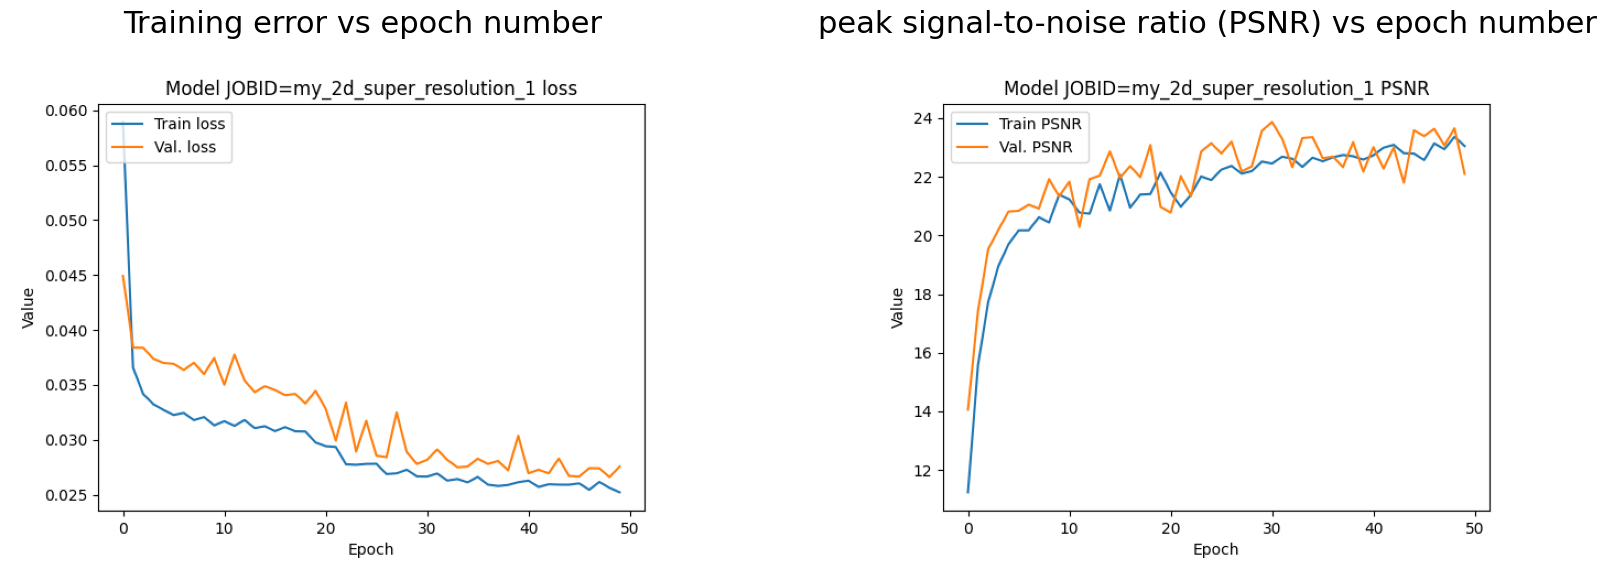

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and PSNR vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

psnr = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_PSNR.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( psnr )
_ = plt.axis('off')
_= ax2.set_title( 'peak signal-to-noise ratio (PSNR) vs epoch number', fontdict = {'fontsize':22})

## **Visualize super-resolution results (from the test set)**
___

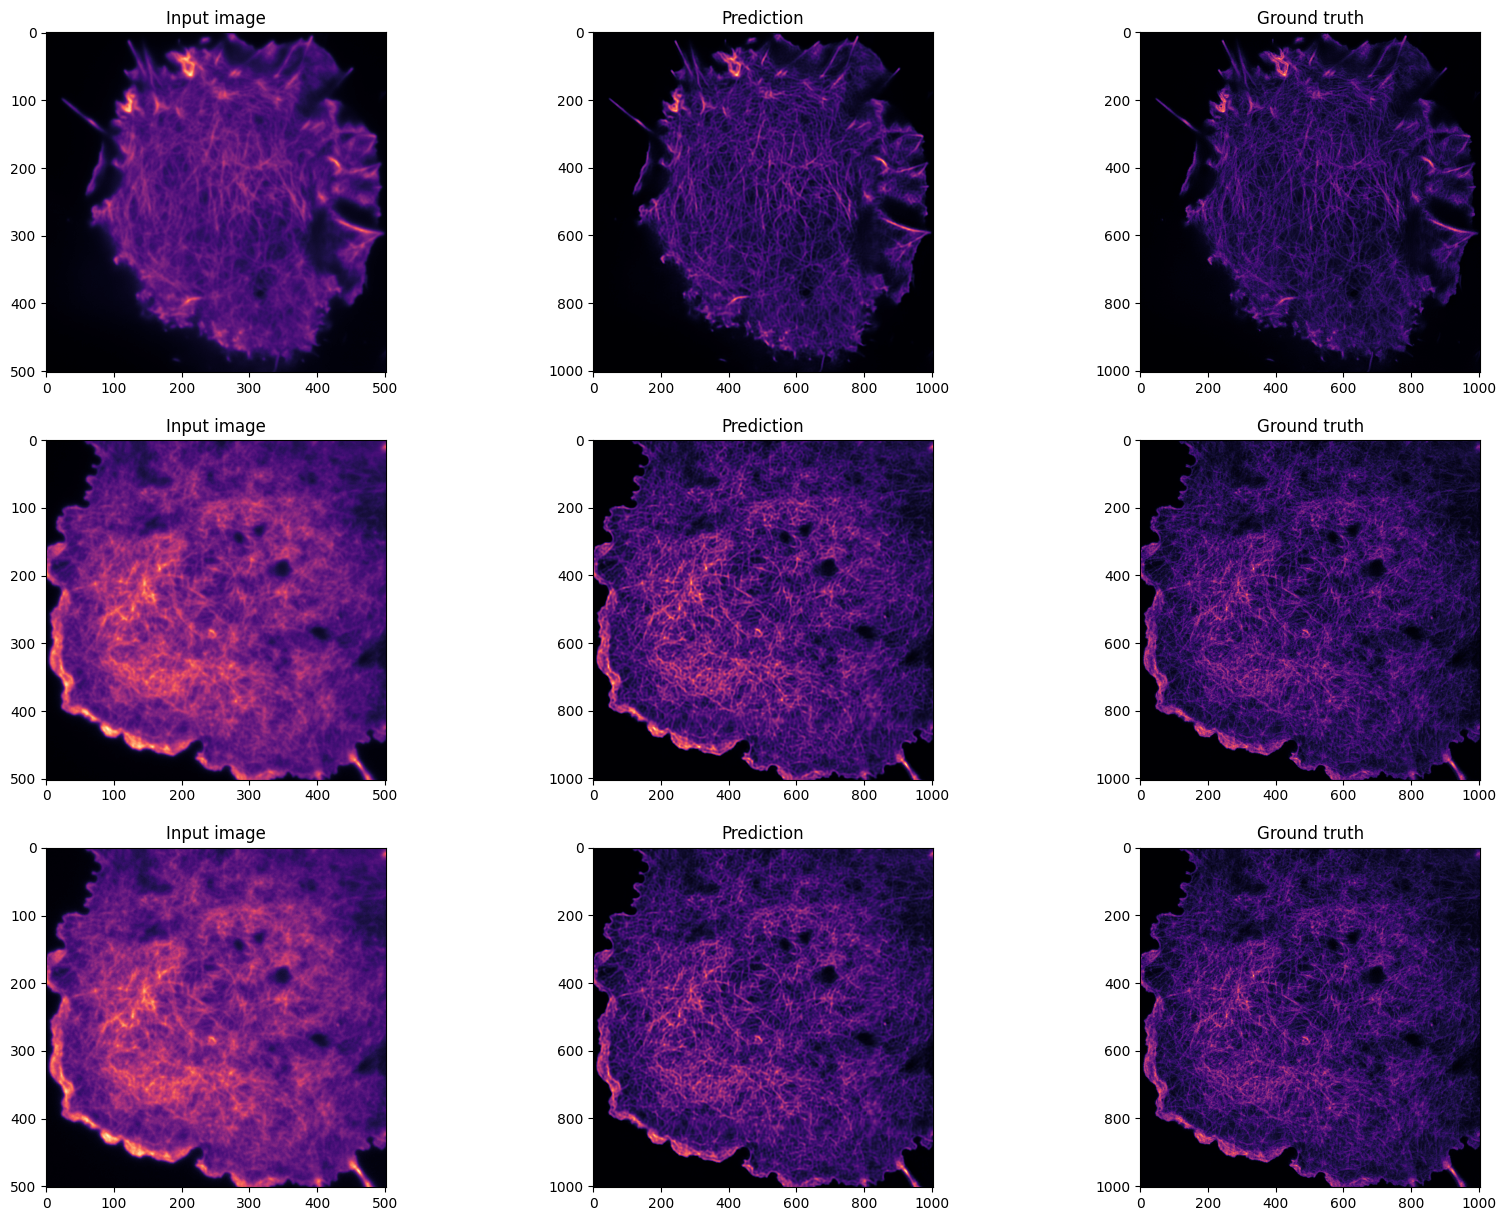

In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

sr_results = os.path.join(final_results, "per_image")

#@markdown ##Play to visualize some results
#@markdown The results will be shown displaying:
#@markdown 1. The original **Input image**
#@markdown 2. The model **Prediction** labels
#@markdown 3. Its corresponding **Ground truth** labels

#@markdown A colormap has been added to the images to facilitate its visualization.

from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(sr_results))[2])
ids_input = sorted(next(os.walk(test_lr_data_path))[2])
ids_gt = sorted(next(os.walk(test_hr_data_path))[2])

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_lr_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(sr_results, ids_pred[chosen_images[i]]))
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_hr_data_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 3, index)
    plt.title("Input image")
    plt.imshow(np.squeeze(test_samples[j]), cmap='magma')

    index = index + 1
    plt.subplot(samples_to_show, 3, index)
    plt.title("Prediction")
    plt.imshow(np.squeeze(test_sample_preds[j]), cmap='magma')

    index = index + 1
    plt.subplot(samples_to_show, 3, index)
    plt.title("Ground truth")
    plt.imshow(np.squeeze(test_sample_gt[j]),  cmap='magma')
    index = index + 1
plt.show()



## **Download train model (weights and configuration file)**
___
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)
config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))


## **Export your model to BioImage Model Zoo format:**
___

If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [ ]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

# ------------- User input ------------
# information about the model
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "[First Author, Second Author, Third Author]" #@param {type:"string"}
trained_model_authors_affiliation =  "[First Author Affiliation, Second Author Affiliation, Third Author Affiliation]" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = ["Ronneberger et al. arXiv in 2015", "Franco-Barranco, Daniel, et al. ISBI in 2023"] #@param {type:"string"}
trained_model_references_DOI = ["10.1007/978-3-319-24574-4_28","10.1109/ISBI53787.2023.10230593"] #@param {type:"string"}
trained_model_tags = "modality: electron-microscopy, content: mitochondria" #@param {type:"string"}
trained_model_documentation = "/content/README.md" #@param {type:"string"}


In [ ]:
#@markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model
# update BMZ export parameters

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:
    from google.colab import files

    # create the author spec input
    auth_names = trained_model_authors[1:-1].split(",")
    auth_affs = trained_model_authors_affiliation[1:-1].split(",")
    assert len(auth_names) == len(auth_affs)
    authors = [{"name": auth_name, "affiliation": auth_aff} for auth_name, auth_aff in zip(auth_names, auth_affs)]

    # create the citation input spec
    assert len(trained_model_references_DOI) == len(trained_model_references)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(trained_model_references, trained_model_references_DOI)]

    tags = [{t.split(":")[0]: t.split(":")[1]} for t in trained_model_tags.split(",")]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Gizmo"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=[{'modality': 'electron-microscopy', 'content': 'mitochondria'}]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    bmz_cfg['doc'] = trained_model_documentation

    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)

bmz_zip_path = f"/content/{trained_model_name}.bmz.zip"
if os.path.isdir(bmz_results):
    !zip -r $bmz_zip_path $bmz_results
else:
    print("The model was not exported to this format")

files.download(bmz_zip_path)

## **How to use the trained model with new data**
___
To directly infer new data to the trained model, you can use [this notebook](https://github.com/BiaPyX/BiaPy/blob/master/notebooks/BiaPy_Inference.ipynb). It will be necessary to upload the downloaded YAML configuration file and model weights to that notebook.

## **Acknowledgments**
___

We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.
